# Inverted index dengan TF-IDF KELOMPOK 2



---






## Import Library

In [1]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 3.5 MB/s eta 0:00:00a 0:00:01


In [2]:
import math

import nltk

import operator

from nltk import word_tokenize

stemmer = nltk.stem.PorterStemmer()

In [3]:
# Download the 'punkt' resource

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from sentence_transformers import SentenceTransformer, util

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Cleaning and indexing

In [5]:
def clean_tokenize(doc):

    words = word_tokenize(doc.lower())

    return words



def index_one_doc(doc,to_stem):

    '''

    creates dict (tok,positions) for each tok in the document (as term list)

    '''

    tokpos = dict()

    for t_idx,tok in enumerate(doc):

        if to_stem:

           tok = stemmer.stem(tok)

        if tok in tokpos:

            tokpos[tok].append(t_idx)

        else:

            tokpos[tok] = [t_idx]

    return tokpos

##Load Dataset

In [ ]:
import pandas as pd



docs = pd.read_excel("/kaggle/input/dataset-kelompok2/Kelompok2_new.xlsx")


selected_columns = docs[['docs', 'pasal']]


title = selected_columns.apply(lambda row: f"{row['docs']} {row['pasal']}", axis=1).tolist()



docs = docs["tentang"].to_list()

docs = [str(doc) if isinstance(doc, float) else doc for doc in docs]



cleaned_docs = []

for doc in docs:

    print(doc)

    to_app = clean_tokenize(str(doc))

    cleaned_docs.append(to_app)



print(cleaned_docs)

##Stem dan Membuat Dictionary Kosa Kata

In [7]:
inverted_index = dict()
inverted_index_stem = dict()

for d_idx,doc in enumerate(cleaned_docs):

    poslists_s = index_one_doc(doc,to_stem=True) # get positions of each token in the doc
    for tok,poslist_s in poslists_s.items():
        if tok in inverted_index_stem:
            inverted_index_stem[tok][d_idx] = poslist_s # update
        else:
            inverted_index_stem[tok] = dict()
            inverted_index_stem[tok][d_idx] = poslist_s # initialize

    poslists = index_one_doc(doc,to_stem=False)
    for tok,poslist in poslists.items():
        if tok in inverted_index:
            inverted_index[tok][d_idx] = poslist
        else:
            inverted_index[tok] = dict()
            inverted_index[tok][d_idx] = poslist

##Membuat Fungsi Indexing

In [8]:
def at_least_one_unigram(query,inverted_index):

    '''
    returns the indexes of the docs containing *at least one* query unigrams

    the query is a list of unigrams

    '''



    to_return = []

    for unigram in query:

        if unigram in inverted_index:

            to_return.extend(list(inverted_index[unigram].keys()))

    return list(set(to_return))



def all_unigrams(query,inverted_index):

    '''

    returns the indexes of the docs containing *all* query unigrams

    the query is a list of unigrams

    '''



    to_return = []

    for unigram in query:

        if unigram in inverted_index:

            to_return.append(set(list(inverted_index[unigram].keys())))

        else:

            to_return.append(set())

            break

    to_return = to_return[0].intersection(*to_return)

    return list(to_return)



def ngrams(query,inverted_index):

    '''

    returns the indexes of the docs containing all unigrams in same order as the query

    the query is a list of unigrams

    '''

    candidate_docs = all_unigrams(query,inverted_index)



    to_return = []

    for doc in candidate_docs:

        poslists = []

        for unigram in query:

            to_append = inverted_index[unigram][doc]

            if isinstance(to_append, int):

                poslists.append([to_append])

            else:

                poslists.append(to_append)

        # test whether the query words are consecutive

        poslists_sub = [[elt-idx for elt in poslist] for idx,poslist in enumerate(poslists)]

        if set(poslists_sub[0]).intersection(*poslists_sub):

            to_return.append(doc)

    return to_return

##Testing Indexing

In [9]:
query = "Kasus Cuci Uang"

split_query = query.split()

query_stemmed = [stemmer.stem(elt) for elt in split_query]

print(at_least_one_unigram(query_stemmed,inverted_index))

[162]


###Training

In [4]:
import pandas as pd

# Load dataset
df = pd.read_excel("/kaggle/input/dataset-kelompok2/Kelompok2_new.xlsx")

# Ensure labels are in float format for similarity tasks
df['label'] = df['label'].astype(float)

In [5]:
df

,docs,pasal,tentang,query,label
0,Peraturan Komnas HAM Nomor 2 Tahun 2019,25,1. Komisi Nasional Hak Asasi Manusia yang sela...,Kewenangan Kepemimpinan kolektif kolegial,1.0
1,Peraturan Komnas HAM Nomor 2 Tahun 2019,25,1. Komisi Nasional Hak Asasi Manusia yang sela...,Hukum kasus penipuan online,0.0
2,Peraturan Komnas HAM Nomor 2 Tahun 2019,26,(1) Komisi Nasional Hak Asasi Manusia yang sel...,Komnas HAM setingkat dengan lembaga lainnya,1.0
3,Peraturan Komnas HAM Nomor 2 Tahun 2019,26,(1) Komisi Nasional Hak Asasi Manusia yang sel...,Pasal pencucian uang terhadap perusahaan,0.0
4,Peraturan Komnas HAM Nomor 2 Tahun 2019,27,(1) Apabila Ketua Komnas HAM meninggal atau be...,prosedur pemilihan dan penetapan Ketua penggan...,1.0
...,...,...,...,...,...
175,Peraturan Komnas HAM Nomor 6 Tahun 2020,4,Bentuk dan susunan JRA Komnas HAM sebagaimana ...,Bentuk dan susunan Jadwal Retensi Arsip (JRA) ...,1.0
176,Peraturan Komnas HAM Nomor 6 Tahun 2020,5,(1) Penentuan masa retensi arsip dihitung seja...,Penentuan masa retensi arsip dimulai sejak keg...,1.0
177,Peraturan Komnas HAM Nomor 6 Tahun 2020,6,Keterangan tentang penetapan suatu jenis arsip...,Penetapan arsip: a) Dinilai kembali jika berpo...,1.0
178,Peraturan Komnas HAM Nomor 6 Tahun 2020,7,JRA Komnas HAM sebagaimana dimaksud dalam Pasa...,JRA Komnas HAM tercantum dalam Lampiran dan me...,1.0


In [45]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AdamW
import torch
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.nn.functional import cosine_similarity
import numpy as np

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer from HuggingFace Hub, and move model to device
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModel.from_pretrained("indolem/indobert-base-uncased").to(device)
# model.load_state_dict(torch.load('/kaggle/working/2_lossvalid0.02850815818263226.pth'))

In [36]:
new_ds = load_dataset("genta-tech/squad_pairs_indo")

README.md:   0%|          | 0.00/746 [00:00<?, ?B/s]

(…)-00000-of-00001-dfbd22e636198aff.parquet:   0%|          | 0.00/8.15M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

In [37]:
train_new_pair = new_ds['train'].select(range(43000))
train_new_pair = train_new_pair.rename_column('0', 'sentence1')
train_new_pair = train_new_pair.rename_column('1', 'sentence2')
train_new_pair = train_new_pair.add_column('score', np.ones(len(train_new_pair), dtype=np.float64))

train_new_npair = new_ds['train'].select(range(43000, 86000))
train_new_npair = train_new_npair.rename_column('0', 'sentence1')
train_new_npair = train_new_npair.rename_column('1', 'sentence2')
train_new_npair = train_new_npair.add_column('score', np.zeros(len(train_new_pair), dtype=np.float64))

In [38]:
# Geser kolom 'sentence2' ke bawah sejauh 10 baris
shift_amount = 10
column_1 = train_new_npair['sentence2']
column_2 = train_new_npair['score']

# Geser kolom dengan mengambil bagian akhir dan menempelkannya ke bagian awal
shuffled_column_1 = column_1[-shift_amount:] + column_1[:-shift_amount]

# Buat dataset baru dengan kolom 'sentence2' yang sudah digeser
train_new_npair = train_new_npair.remove_columns(['sentence2', 'score'])
train_new_npair = train_new_npair.add_column('sentence2', shuffled_column_1)
train_new_npair = train_new_npair.add_column('score', column_2)

In [39]:
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Load the dataset
ds = load_dataset("quarkss/stsb-indo-mt")

# Split the dataset
# Round the scores in the train dataset
train_data = concatenate_datasets([ds['train'], ds['test'],ds['validation'],train_new_pair,train_new_npair])
train_data = train_data.shuffle(seed=42) 
train_data = train_data.select(range(int(len(train_data) * 0.9)))
train_data = train_data.map(lambda example: {"score": 1 if example['score'] > 0.5 else 0})

# Round the scores in the validation dataset
valid_data = train_data.select(range(int(len(train_data) * 0.9), len(train_data)))
valid_data = valid_data.map(lambda example: {"score": 1 if example['score'] > 0.5 else 0})

# Custom dataset class
class TextPairDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence1 = self.data[idx]['sentence1']
        sentence2 = self.data[idx]['sentence2']
        score = self.data[idx]['score']
        
        return {
            'sentence1': sentence1,
            'sentence2': sentence2,
            'score': torch.tensor(score, dtype=torch.float)
        }

# Create datasets
train_dataset = TextPairDataset(train_data, tokenizer)
valid_dataset = TextPairDataset(valid_data, tokenizer)

README.md:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

data/stsb.train.csv:   0%|          | 0.00/855k [00:00<?, ?B/s]

data/stsb.validation.csv:   0%|          | 0.00/242k [00:00<?, ?B/s]

data/stsb.test.csv:   0%|          | 0.00/193k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Map:   0%|          | 0/85165 [00:00<?, ? examples/s]

Map:   0%|          | 0/8517 [00:00<?, ? examples/s]

In [42]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=24, shuffle=False)

In [43]:
class CustomCosineLoss(nn.Module):
    def __init__(self):
        super(CustomCosineLoss, self).__init__()

    def forward(self, embeddings1, embeddings2, label, margin=0.5):
        cosine_sim = F.cosine_similarity(embeddings1, embeddings2)
        loss = torch.mean((label * (1 - cosine_sim)) + ((1 - label) * F.relu(cosine_sim - margin)))
        return loss

class contrastive_loss(nn.Module):
    def __init__(self):
        super(contrastive_loss, self).__init__()

    def forward(self, embedding_a, embedding_b, label, margin=0.5):
        cosine_sim = F.cosine_similarity(embedding_a, embedding_b)
        print(label)
        print(cosine_sim)
        positive_loss = label * (1 - cosine_sim)
        negative_loss = (1 - label) * F.relu(cosine_sim - margin)
        loss = torch.mean(positive_loss + negative_loss)
        return loss

In [ ]:
# Initialize the custom loss
CosineLoss = CustomCosineLoss()
ContrastiveLoss = contrastive_loss()
# cross_entropy_loss = nn.CrossEntropyLoss()

# Set up optimizer for the model
optimizer = AdamW(params=model.parameters(), lr=2e-5, correct_bias=True, weight_decay=0.01)

# Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)

    # Compute token embeddings
    model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings.to(device)  # Ensure embeddings are on the correct device

# Custom Training Loop
num_epochs = 20
loss_before = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        # Prepare batch data
        sentences1_batch = batch['sentence1']
        sentences2_batch = batch['sentence2']
        labels_batch = batch['score'].to(device)

        optimizer.zero_grad()  # Clear the gradients from the previous step
        # Encode sentences and ensure embeddings are on the correct device
        embeddings_a = encode(sentences1_batch)
        embeddings_b = encode(sentences2_batch)

        # Compute the loss
        # loss = custom_loss(sentences1_batch_tensor, sentences2_batch_tensor, labels_batch)
        # loss = cross_entropy_loss(scores, labels_batch)

        loss = CosineLoss(embeddings_a, embeddings_b, labels_batch)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()  # Compute gradient
        optimizer.step()  # Update the model's parameters

    # Print the average loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1} Average Training Loss: {avg_loss}')

    # Evaluate on validation set
    model.eval()
    total_loss = 0
    for batch in valid_dataloader:
        # Prepare batch data
        sentences1_batch = batch['sentence1']
        sentences2_batch = batch['sentence2']
        labels_batch = batch['score'].to(device)
        with torch.no_grad():
            # Encode sentences and ensure embeddings are on the correct device
            embeddings_a = encode(sentences1_batch)
            embeddings_b = encode(sentences2_batch)
    
            # Compute loss
            # scores = torch.mm(embeddings_a, embeddings_b.transpose(0, 1)) * 1
            # labels_batch = labels_batch.long()
            # loss = (cross_entropy_loss(scores, labels_batch) + cross_entropy_loss(scores.transpose(0, 1), labels_batch)) / 2
            loss = CosineLoss(embeddings_a, embeddings_b, labels_batch)
            total_loss += loss.item()

    # Print the average loss for this epoch
    avg_loss = total_loss / len(valid_dataloader)
    print(f'Epoch {epoch+1} Average Validation Loss: {avg_loss}')
    if loss_before > avg_loss:
        torch.save(model.state_dict(), f"{epoch+1}_lossvalid{avg_loss}.pth")
        loss_before = avg_loss

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Average Training Loss: 0.11790247289908021
Epoch 1 Average Validation Loss: 0.04683647383279889


Epoch 2/20:  20%|██        | 719/3549 [05:07<19:47,  2.38it/s]

In [32]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings


# Sentences we want sentence embeddings for
query = "Saya adalah beruang kutub sedang meluncur di atas salju"
docs = ["Seekor beruang kutub meluncur di atas salju.", "dia pencuri yang handal", "saya suka ice cream"]

#Encode query and docs
query_emb = encode(query)
doc_emb = encode(docs)

#Compute dot score between query and all document embeddings
scores = torch.mm(query_emb, doc_emb.transpose(0, 1))[0].cpu().tolist()

#Combine docs & scores
doc_score_pairs = list(zip(docs, scores))

#Sort by decreasing score
doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)

#Output passages & scores
for doc, score in doc_score_pairs:
    print(score, doc)

0.681152880191803 Seekor beruang kutub meluncur di atas salju.
0.5844601988792419 saya suka ice cream
0.542510449886322 dia pencuri yang handal


180
[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
180
tensor([0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.,

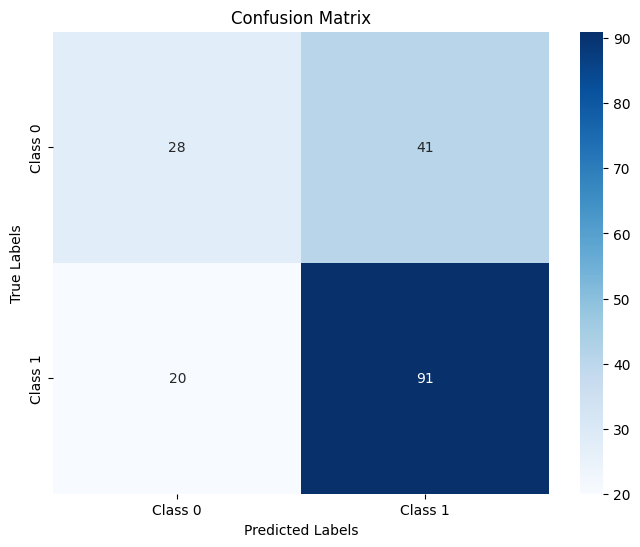

In [34]:
import torch
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

query_str = df['query'].tolist()
doc_str = df['tentang'].tolist()
predictions = []

# Langkah 1: Encode query dan dokumen
for i in range(len(query_str)):
    predictions.append(torch.mm(encode(str(query_str[i])), encode(str(doc_str[i])).transpose(0, 1)))

# Convert predictions to tensor
predictions = torch.stack(predictions)
predictions = predictions.cpu()
predictions = (predictions >= 0.5).float()

# Langkah 4: Hitung F1-score
true_labels = df['label'].tolist()  # Label yang benar dari dataframe

print(len(true_labels))
print(true_labels)
print(len(predictions))
print(predictions.flatten())

# Calculate F1-score
f1 = f1_score(true_labels, predictions.flatten(), average='weighted')
print("F1-score:", f1)

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions.flatten())

# Print confusion matrix details
tn, fp, fn, tp = cm.ravel()  # unpacking values for confusion matrix
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Precision, Recall, and F1 Score per class
precision = precision_score(true_labels, predictions.flatten(), average='weighted')
recall = recall_score(true_labels, predictions.flatten(), average='weighted')
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)

# Full classification report
report = classification_report(true_labels, predictions.flatten())
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()